In [1]:
import os
import yaml
import time
import torch 
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import joblib
from geopy.distance import geodesic
from torch.utils.data import DataLoader, TensorDataset, random_split 

# Personnal function
from functions_models import point_space_boundaries
from functions_models.collect_mini_cubes import *
from functions_models.apply_transformation import apply_transformation
from functions_models.fill_nan_with_mean import fill_nan_with_mean
from functions_models.add_current import add_current
from functions_models.apply_bathy_mask import apply_bathy_mask
from functions_models.usefull_function_model import *
from functions_models.build_data_loader import build_data_loader
from functions_models.train_val_loop import train_val_loop, train_val_loop_l2 
from functions_models.models_archi import *

def compute_target_quantiles(train_loader, quantile=0.15, pfts=False, device='cpu'):
    all_targets = []

    for targets in train_loader:
        targets = targets[1].to(device)
        all_targets.append(targets)

    all_targets = torch.cat(all_targets, dim=0)

    if not pfts:
        # (N,) → une seule cible
        all_targets = all_targets.view(-1)
        q_low = torch.quantile(all_targets, quantile)
        q_high = torch.quantile(all_targets, 1 - quantile)
        return q_low, q_high
    else:
        # (N, 3) → 3 cibles : une paire par dimension
        q_low = []
        q_high = []
        for i in range(all_targets.shape[1]):
            col = all_targets[:, i]
            q_low.append(torch.quantile(col, quantile))
            q_high.append(torch.quantile(col, 1 - quantile))
        return torch.stack(q_low), torch.stack(q_high)
    
def create_new_training_folder(base_path, pfts=False):
    import re
    """
    Crée un nouveau dossier de type train_{x} dans base_path,
    en incrémentant automatiquement x.

    Args:
        base_path (str): Le chemin de base où créer les dossiers train_{x}.

    Returns:
        str: Le chemin complet du nouveau dossier créé.
    """
    # Créer le dossier de base s'il n'existe pas
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Lister les dossiers existants de type train_{x}
    existing_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    train_dirs = [d for d in existing_dirs if re.match(r'^train_\d+$', d)]
    if pfts : 
        train_dirs = [d for d in existing_dirs if re.match(r'^train_pfts_\d+$', d)]

    # Extraire les indices
    indices = [int(re.search(r'\d+', d).group()) for d in train_dirs]
    next_index = max(indices) + 1 if indices else 1

    # Créer le nouveau dossier
    if pfts :
        new_dir_name = f"train_pfts_{next_index}"
    else : 
        new_dir_name = f"train_{next_index}"
        
    new_dir_path = os.path.join(base_path, new_dir_name)
    os.makedirs(new_dir_path, exist_ok=True)

    return new_dir_path

import os
import torch
import joblib
import numpy as np
import json
from scipy.special import boxcox1p, inv_boxcox
def plot_score2(prediction, true, text, latitude, output_link=False, axis_log=True,
               xlabel='True', ylabel='Prediction', PFTS=False, liste_med=None):

    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    from matplotlib.ticker import ScalarFormatter

    # Conversion tensors -> numpy
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.detach().cpu().numpy()
    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
    if isinstance(latitude, torch.Tensor):
        latitude = latitude.detach().cpu().numpy()
    if isinstance(liste_med, torch.Tensor):
        liste_med = liste_med.detach().cpu().numpy()

    prediction = np.ravel(prediction)
    true = np.ravel(true)
    latitude = np.ravel(latitude)

    # ➤ Remplacer les valeurs ≤ 0 par un seuil minimum pour affichage log
    min_val_log = 1e-4
    prediction = np.where(prediction <= 0, min_val_log, prediction)
    true = np.where(true <= 0, min_val_log, true)

    # Calcul des métriques
    N = len(prediction)
    r2, num_2, num_4, den_2, den_4 = function_r2(prediction, true)
    slope = function_slope(prediction, true)
    MAPD = function_MAPD(prediction, true)
    RMSD = function_RMSD(prediction, true)

    # Affichage
    plt.figure(figsize=(10, 6))

    metrics_text = (f'R² = {r2:.2f}\n'
                    f'MAPD = {MAPD:.2f} %\nRMSD = {RMSD:.4f} mg.m$^3$')
    plt.text(0.02, 0.8, metrics_text, transform=plt.gca().transAxes,
             fontsize=18, multialignment='left')

    # Ligne d'identité
    line = np.linspace(1e-6, 100, 100)
    plt.plot(line, line, color='lightgrey', linestyle='--', linewidth=1.5)

    label = 'Latitude'
    if hasattr(latitude, "name") and latitude.name == "CHL_less_tchla":
        label = 'OC CCI error (tchla_oc_cci - tchla_hplc)'

    use_color = latitude.shape[0] == prediction.shape[0]

    if use_color:
        scatter = plt.scatter(true, prediction, c=latitude, cmap='coolwarm', s=60)
        scatter.set_clim(-90, 90)
        cbar = plt.colorbar(scatter)
        cbar.set_label(label, fontsize=18)
        cbar.ax.tick_params(labelsize=18)
    else:
        plt.scatter(true, prediction, color='gray', s=60)

    # Option coloration Méditerranée
    if liste_med is not None:
        liste_med = np.ravel(liste_med)
        is_med = liste_med == 1
        is_other = ~is_med

        plt.scatter(true[is_other], prediction[is_other], color='#a6a6a6', s=60, label='Other')
        plt.scatter(true[is_med], prediction[is_med],
                    facecolors='#F59D7E',
                    linewidths=1.5, s=60, label='Mediterranean Sea')

    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    if axis_log:
        plt.xscale('log')
        plt.yscale('log')

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_scientific(False)

    # Ticks log personnalisés
    if PFTS:
        ticks = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
        tick_labels = ['0.0001', '0.001', '0.01', '0.1', '1', '10']
        plt.xlim(1e-4, 15 + 1.5)
        plt.ylim(1e-4, 15 + 1.5)
    else:
        ticks = [1e-2, 1e-1, 1, 10]
        tick_labels = [ '0.01', '0.1', '1', '10']
        plt.xlim(1e-2, 15 + 1.5)
        plt.ylim(1e-2, 15 + 1.5)


    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, fontsize=20)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=20)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f'{text}', fontsize=20)

    if output_link:
        plt.savefig(output_link, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()

def evaluate_model(dataloader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, suffix, set_type):
    # Map pour filtrage selon set_type
    set_code_map = {'train': 0, 'val': 1, 'test': 2}
    set_code = set_code_map[set_type]

    model_trained.eval()
    prediction_set = []
    true_set = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            if model != 3:
                images[images == -10] = float('nan')
                images = images.nanmean(dim=(2, 3))
            outputs = model_trained(images.float())
            prediction_set.append(outputs.cpu())
            true_set.append(labels.cpu())

    prediction_set = torch.cat(prediction_set, dim=0)
    true_set = torch.cat(true_set, dim=0)

    df_set = df_mini_cubes[df_mini_cubes[:, 9] == set_code]
    df_set_lat = df_set[:, 0]

    if pfts:
        keys = ["Micro_Chla", "Nano_Chla", "Pico_Chla"]
        short_keys = ["micro", "nano", "pico"]
    
        predictions = {}
        truths = {}
    
        # Charger le dico contenant les stats (mean/std, boxcox lambda)
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
    
        for i, key in enumerate(keys):
            short_key = short_keys[i]
    
            # Charger quantile transformer
            #transfo_path = os.path.join(path_dico, f"{key}_quantile_transformer.pkl")
            #if not os.path.exists(transfo_path):
            #    raise FileNotFoundError(f"Missing transformer: {transfo_path}")
            #transformer = joblib.load(transfo_path)
            
            # Récupérer données
            pred_i = prediction_set[:, i].detach().cpu().numpy().reshape(-1, 1)
            true_i = true_set[:, i].detach().cpu().numpy().reshape(-1, 1)

            # Inversed factor 
            #pred_i = pred_i*(3/2)
            #true_i = true_i*(3/2)
    
            # Inverse quantile transform
            #pred_i = transformer.inverse_transform(pred_i).flatten()
            #true_i = transformer.inverse_transform(true_i).flatten()
    
            # Déstandardisation
            mean = dico[f"{key}_standardization_mean"]
            std = dico[f"{key}_standardization_std"]
            pred_i = pred_i * std + mean
            true_i = true_i * std + mean

            # Déboxcox
            lmbda = dico[f"{key}_boxcox_lmbda"]
            pred_i = inv_boxcox(pred_i, lmbda)
            true_i = inv_boxcox(true_i, lmbda)
    
            # if values lower than 10e-5 put it to 0 
            print("Value < 10e-5 : ", pred_i[pred_i < 1e-5].shape)
            pred_i[pred_i < 1e-5] = 0
            true_i[true_i < 1e-5] = 0
            print("Value < 10e-5 after: ", pred_i[pred_i < 1e-5].shape)
    
            predictions[short_key] = pred_i.tolist()
            truths[short_key] = true_i.tolist()

        # Plot pour chaque PFT
        for pft in short_keys:
            x_label = f'HPLC {pft}-Chla (mg.m$^{{-3}}$)'
            y_label = f'{y_label_name} \n {pft}-Chla (mg.m$^{{-3}}$)'
            output_file = os.path.join(path_save_all, f'{pft}_{suffix}_plot.png')

            plot_score2(
                predictions[pft],
                truths[pft],
                main_title,
                df_set_lat,
                output_link=output_file,
                axis_log=True,
                xlabel=x_label,
                ylabel=y_label,
                PFTS=True
            )
    else:
        #TChla_path = os.path.join(path_dico, "TChla_quantile_transformer.pkl")
        #quantile_transformer = joblib.load(TChla_path)
        key = "TChla"
        short_key = "tchla"
    
        predictions = {}
        truths = {}
    
        # Charger le dico contenant les stats (mean/std, boxcox lambda)
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
        prediction_set = prediction_set.cpu().numpy().reshape(-1, 1)
        true_set = true_set.cpu().numpy().reshape(-1, 1)

        # Déstandardisation
        mean = dico[f"{key}_standardization_mean"]
        std = dico[f"{key}_standardization_std"]
        pred_i = prediction_set * std + mean
        true_i = true_set * std + mean

        # Déboxcox
        lmbda = dico[f"{key}_boxcox_lmbda"]
        pred_i = inv_boxcox(pred_i, lmbda)
        true_i = inv_boxcox(true_i, lmbda)
    
       
        #predictions = quantile_transformer.inverse_transform(prediction_set)
        #truths = quantile_transformer.inverse_transform(true_set)

        x_label = f'HPLC Total-Chla (mg.m$^{{-3}}$)'
        y_label = f'{y_label_name} \n Total-Chla (mg.m$^{{-3}}$)'
        output_file = os.path.join(path_save_all, f'tchla_{suffix}_plot.png')
        plot_score2(pred_i, true_i , main_title, df_set_lat, output_link=output_file, axis_log=True, xlabel=x_label, ylabel=y_label)
         


In [7]:
import os
import yaml
import time
import torch 
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
from geopy.distance import geodesic
from torch.utils.data import DataLoader, TensorDataset, random_split 


def build_data_loader(login, image_size, model, pfts, device, batch_size, dataset, path_dico, threshold, same_dataset=False, dataset_selected_only_rrs=False):
    #specific_dataset = f"/{dataset}/threshold_{threshold}/"
    space_buffer = int(image_size/2)
    path = f'{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process_split_analysed/dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}/'
    #os.makedirs(path, exist_ok=True)

    if same_dataset:
        picture = torch.load(os.path.join(path, f'picture_{image_size}_common.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'df_{image_size}_common.pt'), weights_only=False)
    elif dataset_selected_only_rrs:
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_MLP_rrs_selected.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_MLP_rrs_selected.pt'), weights_only=False)
    elif model == 3:
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_CNN_boxcox.pt'), weights_only=False)
    else : 
        picture = torch.load(os.path.join(path, f'final_picture_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)
        df = torch.load(os.path.join(path, f'final_df_{image_size}x{image_size}_MLP_boxcox.pt'), weights_only=False)

    valid_mask = ~torch.isnan(df[:, 6])
    picture = picture[valid_mask]
    df = df[valid_mask]

    if model == 1:
        inputs = picture[:, 8:14, :, :].to(device)
    else:
        inputs = picture[:, :14, :, :].to(device)

    target = df[:, 5].to(device)
    if pfts:
        target = df[:, 6:9].to(device)
    set_column = df[:, 9].to(device)
    benchmark = df[:, 11].to(device)
    if pfts:
        benchmark = df[:, 12:15].to(device)

    train_mask = set_column == 0
    val_mask = set_column == 1
    test_mask = set_column == 2

    train_inputs = inputs[train_mask]
    train_target = target[train_mask]
    train_benchmark = benchmark[train_mask]

    # Data augmentation: ensure low_target and high_target each represent 5% of the training data
    data_augmentation = False
    if data_augmentation:
            total_samples = len(train_target)
            print("Total samples before augmentation:", total_samples)
    
            nb_groups = 5
            bin_edges = torch.linspace(train_target.min(), train_target.max(), steps=nb_groups+1).to(train_target.device)
            bin_indices = torch.bucketize(train_target, bin_edges, right=True) - 1 
    
            frequencies = torch.bincount(bin_indices).float()
            frequencies[frequencies == 0] = 1e-6  # éviter la division par 0
    
            duplication_factors = (1.0 / frequencies**0.5)
            duplication_factors *= (total_samples / duplication_factors.sum())  # normalisation globale
            duplication_factors = duplication_factors.int()
    
            augmented_inputs, augmented_targets, augmented_benchmarks = [], [], []
    
            for bin_id in range(10):
                mask = bin_indices == bin_id
                num_duplicates = duplication_factors[bin_id].item()
    
                if num_duplicates > 0 and mask.sum() > 0:
                    augmented_inputs.append(train_inputs[mask].repeat(num_duplicates, 1, 1, 1))
                    augmented_targets.append(train_target[mask].repeat(num_duplicates))
                    augmented_benchmarks.append(train_benchmark[mask].repeat(num_duplicates))
    
            
            train_inputs = torch.cat([train_inputs] + augmented_inputs)
            train_target = torch.cat([train_target] + augmented_targets)
            train_benchmark = torch.cat([train_benchmark] + augmented_benchmarks)
    
            print("Total samples after augmentation:", len(train_target))

    train_dataset = TensorDataset(train_inputs, train_target, train_benchmark)
    valid_dataset = TensorDataset(inputs[val_mask], target[val_mask], benchmark[val_mask])
    test_dataset = TensorDataset(inputs[test_mask], target[test_mask], benchmark[test_mask])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader, df



In [8]:
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self, input_size, hidden_size_list, output_size, device, p=0.1):
        super(DNN, self).__init__()
        self.device = device
        self.dropout = nn.Dropout(p)

        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()  # <- Ajoute cette ligne

        # Première couche
        self.layers.append(nn.Linear(input_size, hidden_size_list[0]))
        self.activations.append(nn.Tanh())  # activation 1

        # Couches cachées
        for i in range(len(hidden_size_list) - 1):
            self.layers.append(nn.Linear(hidden_size_list[i], hidden_size_list[i + 1]))
            self.activations.append(nn.Tanh())  # activation 2, 3, ...

        # Couche de sortie
        self.output = nn.Linear(hidden_size_list[-1], output_size)

    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = self.dropout(activation(layer(x)))  # chaque couche a sa propre activation
        x = self.output(x)
        return x


In [9]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    login = '/home/elabourdette'
    dataset = "from_pfts_study_reset17072025"

    ### Define yours parameters ###
    nb_training = 1
    image_size = 16
    date_buffer = 1
    space_buffer = int(image_size/2)
    print(image_size, space_buffer)
    
    threshold = 0.99
    model = 2
    pfts = True
    same_dataset = False
    ponderate_loss = False
    #Hyper parameters 
    learning_rate = 10e-4
    batch_size = 100
    nb_epoch = 15000
    
    loss_diff_threshold = 0.002
    training_name = f"all_threshold_{threshold}"

    # Title figures 
    if model == 3 :
        main_title = f'CNN on {image_size}x{image_size} km with optics and physics input'
        y_label_name = f'CNN with Physics'
        model_save_name = "CNN_2.pth"
    elif model == 2 : 
        main_title = f'MLP on {image_size}x{image_size} km with optics and physics input'
        y_label_name = f'MLP with Physics'
        model_save_name = "MLP_2.pth"
    elif model == 1 : 
        main_title = f'MLP on {image_size}x{image_size} km with optics input'
        y_label_name = f'MLP'
        model_save_name = "MLP_1.pth"

    name_loss_picture = "loss_plot"
    if pfts : 
        name_loss_picture += "_pfts"

    name_mapd_picture = "mapd_plot"
    if pfts : 
        name_mapd_picture += "_pfts"
    
    ############## int((image_size/4))
    max_longitude = int((image_size/4))

    path_dico = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}/"
    # Data loader
    train_loader, valid_loader, test_loader, df_mini_cubes = build_data_loader(login, image_size, model, pfts, 'cpu', batch_size, dataset, path_dico, threshold, same_dataset, dataset_selected_only_rrs=False)

    model_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_all_threshold_0.99_boxcox/model_2/space_buffer_8_date_buffer_1/tchla_[70]_lr_7x10e-4_batch_200/train_11/MLP_2.pth"
    #model_path = f"{login}/complex/gdrive/shared/Proj_FORMAL/deep_satellite/Code/CNN/pytorch_process/training_all_threshold_0.99_boxcox/model_2/space_buffer_8_date_buffer_1/pfts_cnn_lr_7x10e-4/train_pfts_2/MLP_2.pth"
    model_dl = DNN(14, [100], 1, device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model_dl.load_state_dict(checkpoint['model_state_dict'])
    model_dl.eval().to(device)
    
    from captum.attr import IntegratedGradients
    
    all_X = []
    all_y = []
    
    for X_batch, y_batch, y_benchmark in train_loader:  
        all_X.append(X_batch)
        all_y.append(y_batch)
    
    X_train_full = torch.cat(all_X, dim=0)
    y_train_full = torch.cat(all_y, dim=0)
    
    print(X_train_full.shape)
    X_train_mean = X_train_full.mean(dim=(2, 3))
    X_train_mean.shape
    
    X = X_train_mean.to(device).clone().detach().requires_grad_(True)
    ig = IntegratedGradients(model_dl)
    baseline = torch.zeros_like(X)  # Ou: X.mean(dim=0, keepdim=True)
    attributions = ig.attribute(X, baselines = baseline,  target=0)


16 8


/tmp/ipykernel_1228093/3000278894.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
/home/elabourdette/miniconda3

torch.Size([2205, 14, 4, 4])


In [12]:
    from alibi.explainers import IntegratedGradients
    X = X_train_mean.to(device).clone().detach().requires_grad_(True)
    ig = IntegratedGradients(model_dl)
    attributions= ig.attribute(X, target=0)
    explanation = ig.explain(X,
                         baselines=None,
                         target=None)

ModuleNotFoundError: No module named 'alibi'

In [62]:
feature_importance = attributions.abs().mean(dim=0)

print("Importance moyenne des features :", feature_importance)


Importance moyenne des features : tensor([0.0869, 0.2120, 0.0706, 0.0589, 0.0907, 0.2042, 0.0724, 0.1696, 0.3736,
        0.7195, 0.4038, 0.2718, 0.2152, 0.0899], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


Importance moyenne des features : tensor([0.0869, 0.2120, 0.0706, 0.0589, 0.0907, 0.2042, 0.0724, 0.1696, 0.3736,
        0.7195, 0.4038, 0.2718, 0.2152, 0.0899], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


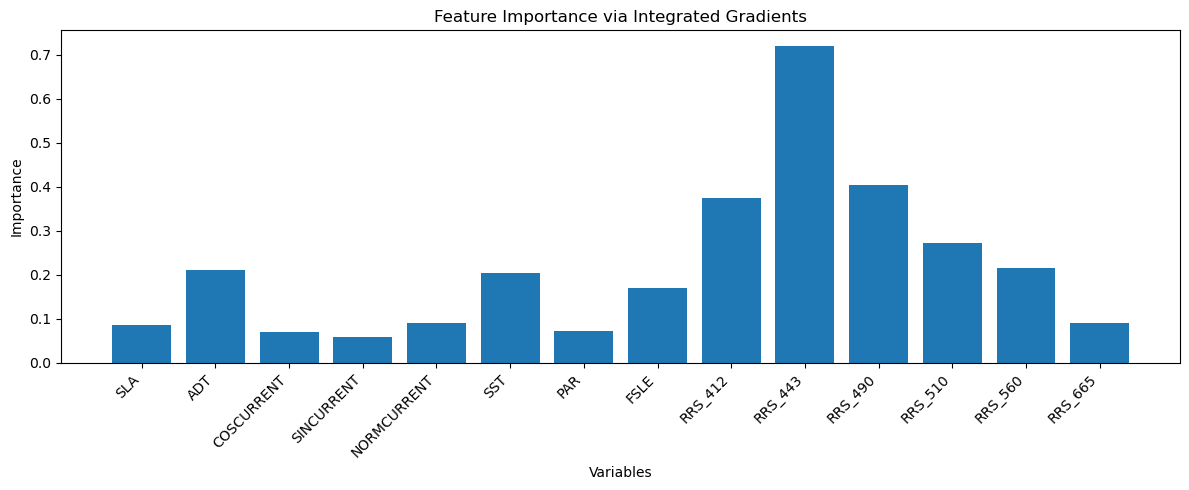

In [67]:
feature_importance = attributions.abs().mean(dim=0)
print("Importance moyenne des features :", feature_importance)

import matplotlib.pyplot as plt

# Définir les noms des variables
tensor_vars = ['SLA', 'ADT', 'COSCURRENT', 'SINCURRENT', 'NORMCURRENT', 'SST', 'PAR', 'FSLE'] + \
              [f'RRS_{w}' for w in [412, 443, 490, 510, 560, 665]]

# Vérification : le nombre de labels doit correspondre à la longueur de feature_importance
assert len(tensor_vars) == len(feature_importance), "Nombre de labels ≠ nombre de features"

# Plot
plt.figure(figsize=(12, 5))

plt.bar(tensor_vars, feature_importance.cpu().detach().numpy())
plt.xticks(rotation=45, ha='right')  # Pour éviter le chevauchement
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance via Integrated Gradients")
plt.tight_layout()
plt.show()


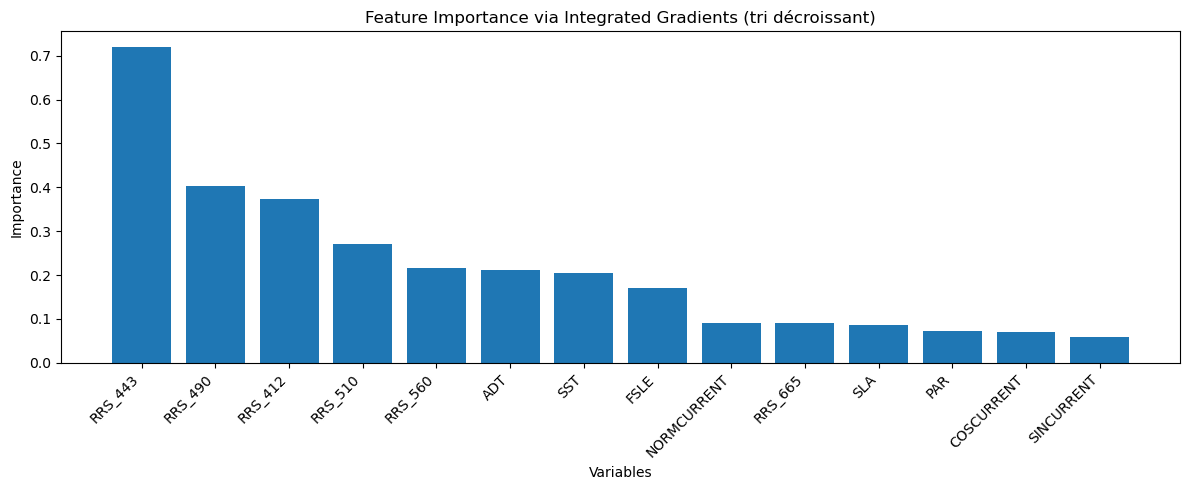

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Conversion en numpy
importance_np = feature_importance.cpu().detach().numpy()

# Tri décroissant
sorted_indices = np.argsort(abs(importance_np))[::-1]
sorted_importance = importance_np[sorted_indices]
sorted_vars = [tensor_vars[i] for i in sorted_indices]

# Plot trié
plt.figure(figsize=(12, 5))
plt.bar(sorted_vars, sorted_importance)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance via Integrated Gradients (tri décroissant)")
plt.tight_layout()
plt.show()


/home/elabourdette/miniconda3/envs/pytorch/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Integrated Gradients: torch.Size([2207, 14])
DeepLift: torch.Size([2207, 14])
DeepLiftShap: torch.Size([2207, 14])


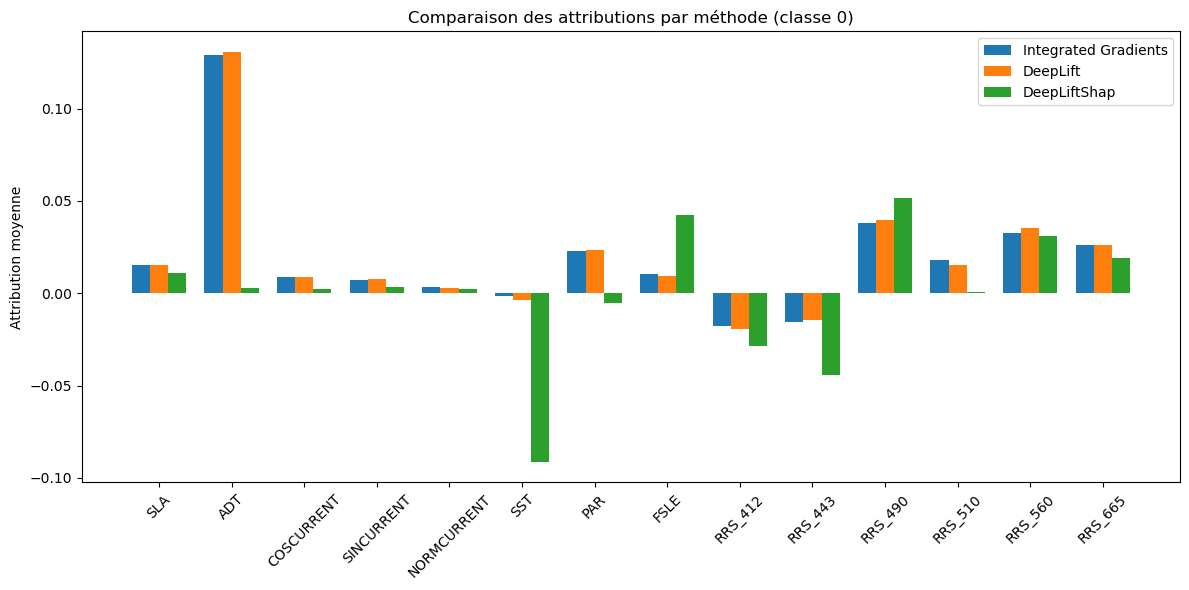

In [39]:


from captum.attr import IntegratedGradients, DeepLift, DeepLiftShap

# Préparation des données d'entrée
X = X_train_mean.to(device).clone().detach().requires_grad_(True)
baseline = torch.zeros_like(X)  # Ou: X.mean(dim=0, keepdim=True)

# Méthodes d'interprétabilité
ig = IntegratedGradients(model_dl)
dl = DeepLift(model_dl)
dl_shap = DeepLiftShap(model_dl)

# Attribution pour la classe 0 (tu peux faire une boucle sur les classes si besoin)
attributions_ig = ig.attribute(X, target=0)
attributions_dl = dl.attribute(X, target=0)
attributions_dlshap = dl_shap.attribute(X, baselines=baseline, target=1)

# Exemple de visualisation simple
print("Integrated Gradients:", attributions_ig.shape)
print("DeepLift:", attributions_dl.shape)
print("DeepLiftShap:", attributions_dlshap.shape)


mean_ig = attributions_ig.mean(dim=0).cpu().detach().numpy()
mean_dl = attributions_dl.mean(dim=0).cpu().detach().numpy()
mean_dlshap = attributions_dlshap.mean(dim=0).cpu().detach().numpy()


import numpy as np
import matplotlib.pyplot as plt
feature_names = ['SLA', 'ADT', 'COSCURRENT', 'SINCURRENT', 'NORMCURRENT', 'SST', 'PAR', 'FSLE'] + \
              [f'RRS_{w}' for w in [412, 443, 490, 510, 560, 665]]
x = np.arange(len(feature_names))  # index des features
width = 0.25  # largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres décalées pour IG, DL et DLShap
ax.bar(x - width, mean_ig, width, label='Integrated Gradients')
ax.bar(x,         mean_dl, width, label='DeepLift')
ax.bar(x + width, mean_dlshap, width, label='DeepLiftShap')

# Labels & titre
ax.set_ylabel('Attribution moyenne')
ax.set_title('Comparaison des attributions par méthode (classe 0)')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [40]:
targets = [0, 1, 2]

# Initialisation des tenseurs d'attribution
attributions_ig_all = []
attributions_dl_all = []
attributions_dlshap_all = []

for t in targets:
    attributions_ig_all.append(ig.attribute(X, target=t))

# Stack pour obtenir un tensor de forme (num_classes, batch_size, num_features)
attr_ig_stack = torch.stack(attributions_ig_all) 


In [44]:
attr_ig_stack.shape
attr_ig_flat = attr_ig_stack.reshape(-1, 14)
mean_ig = attr_ig_flat.mean(dim=0).cpu().detach().numpy() 

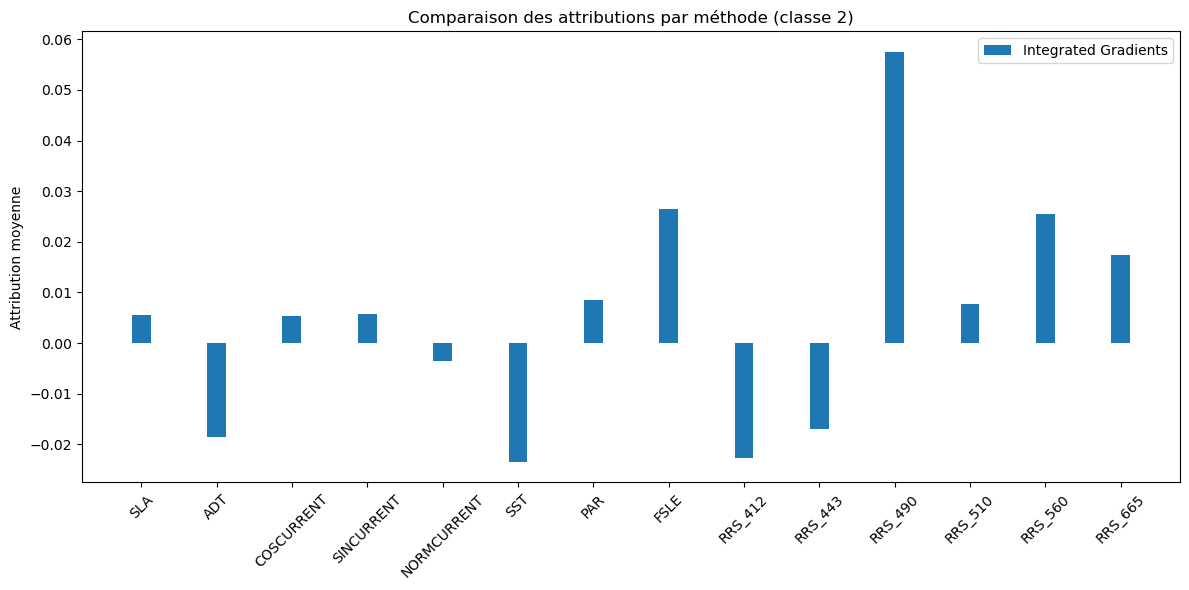

In [45]:

import numpy as np
import matplotlib.pyplot as plt
feature_names = ['SLA', 'ADT', 'COSCURRENT', 'SINCURRENT', 'NORMCURRENT', 'SST', 'PAR', 'FSLE'] + \
              [f'RRS_{w}' for w in [412, 443, 490, 510, 560, 665]]
x = np.arange(len(feature_names))  # index des features
width = 0.25  # largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres décalées pour IG, DL et DLShap
ax.bar(x, mean_ig, width, label='Integrated Gradients')

# Labels & titre
ax.set_ylabel('Attribution moyenne')
ax.set_title('Comparaison des attributions par méthode (classe 2)')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


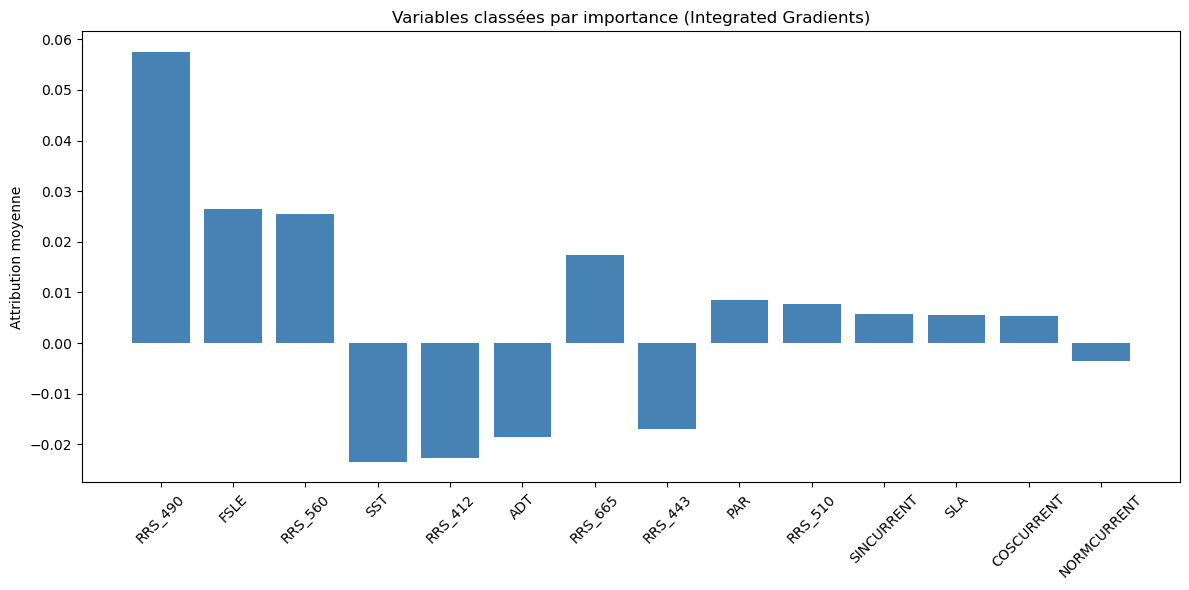

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Tri décroissant des attributions moyennes
sorted_indices = np.argsort(abs(mean_ig))[::-1]  # indices des plus grands vers les plus petits
sorted_mean_ig = mean_ig[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Tracé
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(sorted_mean_ig)), sorted_mean_ig, color='steelblue')
ax.set_xticks(range(len(sorted_mean_ig)))
ax.set_xticklabels(sorted_feature_names, rotation=45)
ax.set_ylabel('Attribution moyenne')
ax.set_title('Variables classées par importance (Integrated Gradients)')
plt.tight_layout()
plt.show()
